# GPT-2 
---
## Study notebook

In [2]:
import tensorflow as tf

In [3]:
tf.enable_eager_execution()

---

In [79]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [77]:
def shape_list_comm(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    print('static:', static)
    dynamic = tf.shape(x)
    print('dynamic:', dynamic)
    for i, s in enumerate(static):
        print(s)
        print(dynamic[i])
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [119]:
t1 = tf.random.normal([4, 3,2], 
                      mean=0.0, 
                      stddev=20,
                      dtype=tf.float32)
print(tf.cast(t1, tf.int16)) # casting to int for readability

tf.Tensor(
[[[-10 -21]
  [-14   9]
  [  1  -8]]

 [[-26   8]
  [  7 -14]
  [-33 -21]]

 [[ 25  14]
  [ -5  -8]
  [ 48  15]]

 [[ 13  18]
  [-36   8]
  [-45   5]]], shape=(4, 3, 2), dtype=int16)


In [78]:
shape_list_comm(t1)

static: [4, 3, 2]
dynamic: tf.Tensor([4 3 2], shape=(3,), dtype=int32)
4
tf.Tensor(4, shape=(), dtype=int32)
3
tf.Tensor(3, shape=(), dtype=int32)
2
tf.Tensor(2, shape=(), dtype=int32)


[4, 3, 2]

---
### Fun star operator
(used e.g. line 46)

In [85]:
*start, m = shape_list(t1)
print(start)
print(m)

[4, 3]
2


---

## Gelu function plotted

In [47]:
import matplotlib.pyplot as plt
import numpy as np

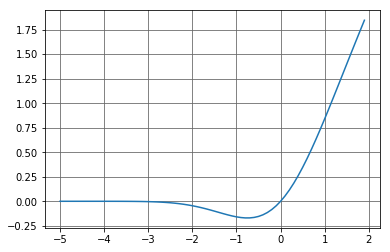

In [54]:
x = np.arange(-5, 2, 0.1)
y = 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(x, y)

---

## Reduce_mean play & other shape fluff

In [68]:
xmean = tf.constant([[1., 1.],
                     [3.,2.],
                     [5., 9.]])
print(tf.reduce_mean(xmean)) # A scalar
print(tf.reduce_mean(xmean, axis=0)) # 'vertical' mean
print(tf.reduce_mean(xmean, axis=1)) # 'horizontal/internal' mean

tf.Tensor(3.5, shape=(), dtype=float32)
tf.Tensor([3. 4.], shape=(2,), dtype=float32)
tf.Tensor([1.  2.5 7. ], shape=(3,), dtype=float32)


In [72]:
xmean.shape.as_list()

[3, 2]

In [92]:
xmean.ndim

2

In [73]:
xmean.shape

TensorShape([Dimension(3), Dimension(2)])

In [138]:
xmean.shape[1]

Dimension(2)

In [91]:
xmean.shape[1].value

2

In [74]:
tf.shape(xmean)

<tf.Tensor: id=616, shape=(2,), dtype=int32, numpy=array([3, 2], dtype=int32)>

In [103]:
print(tf.reshape(xmean, [2,3]))
print(tf.reshape(xmean, [1,6]))

tf.Tensor(
[[1. 1. 3.]
 [2. 5. 9.]], shape=(2, 3), dtype=float32)
tf.Tensor([[1. 1. 3. 2. 5. 9.]], shape=(1, 6), dtype=float32)


---

## Splitting & merging states

In [120]:
def split_states(x, n):
    """Reshape the last dimension of x into [n, x.shape[-1]/n]."""
    *start, m = shape_list(x)
    return tf.reshape(x, start + [n, m//n])

In [129]:
splitx = tf.get_variable("splitx",
                         [2,3,4],
                         tf.float32,
                         initializer=tf.glorot_uniform_initializer)

In [130]:
splitx

<tf.Variable 'splitx:0' shape=(2, 3, 4) dtype=float32, numpy=
array([[[ 0.09519899, -0.5179945 ,  0.60571945, -0.61901444],
        [ 0.5326501 ,  0.6256759 , -0.21402407, -0.07976532],
        [-0.14802265,  0.11726612,  0.35453045,  0.42391026]],

       [[ 0.45691597,  0.24667728,  0.04992068, -0.42152926],
        [ 0.07240939, -0.40548953,  0.5585022 ,  0.50473773],
        [-0.22778407,  0.28633028, -0.44296736, -0.0016287 ]]],
      dtype=float32)>

In [137]:
*start, m = shape_list(splitx)
n = 2
print(start)
print(m)
print(start + [n, m//n])

[2, 3]
4
[2, 3, 2, 2]


In [131]:
splitx_states = split_states(splitx, 2)
splitx_states

<tf.Tensor: id=799, shape=(2, 3, 2, 2), dtype=float32, numpy=
array([[[[ 0.09519899, -0.5179945 ],
         [ 0.60571945, -0.61901444]],

        [[ 0.5326501 ,  0.6256759 ],
         [-0.21402407, -0.07976532]],

        [[-0.14802265,  0.11726612],
         [ 0.35453045,  0.42391026]]],


       [[[ 0.45691597,  0.24667728],
         [ 0.04992068, -0.42152926]],

        [[ 0.07240939, -0.40548953],
         [ 0.5585022 ,  0.50473773]],

        [[-0.22778407,  0.28633028],
         [-0.44296736, -0.0016287 ]]]], dtype=float32)>

In [132]:
def merge_states(x):
    """Smash the last two dimensions of x into a single dimension."""
    *start, a, b = shape_list(x)
    return tf.reshape(x, start + [a*b])

In [133]:
re_splitx = merge_states(splitx_states)
re_splitx

<tf.Tensor: id=803, shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 0.09519899, -0.5179945 ,  0.60571945, -0.61901444],
        [ 0.5326501 ,  0.6256759 , -0.21402407, -0.07976532],
        [-0.14802265,  0.11726612,  0.35453045,  0.42391026]],

       [[ 0.45691597,  0.24667728,  0.04992068, -0.42152926],
        [ 0.07240939, -0.40548953,  0.5585022 ,  0.50473773],
        [-0.22778407,  0.28633028, -0.44296736, -0.0016287 ]]],
      dtype=float32)>

---
## Normalization

Some fluff first:

In [166]:
x = tf.constant([[1.,2.,3.],[4.,5.,6.]])
print('orig', x.numpy(), sep='\n', end='\n----------\n')
y = x - 2.
print('orig -2', y.numpy(), sep='\n', end='\n----------\n')
ysq = tf.square(y)
print('squared', ysq.numpy(), sep='\n', end='\n----------\n')
print('sqr = x^1/2', tf.sqrt(ysq).numpy(), sep='\n', end='\n----------\n')
print('rsqr: 1/(x^1/2), the inf at [0,1] being the reason why they use epsilon', tf.rsqrt(ysq).numpy(), sep='\n', end='\n----------\n') 
print('rsqr: 1/(x^1/2), with epsilon', tf.rsqrt(ysq + 1e-5).numpy(), sep='\n', end='\n----------\n') 

orig
[[1. 2. 3.]
 [4. 5. 6.]]
----------
orig -2
[[-1.  0.  1.]
 [ 2.  3.  4.]]
----------
squared
[[ 1.  0.  1.]
 [ 4.  9. 16.]]
----------
sqr = x^1/2
[[1. 0. 1.]
 [2. 3. 4.]]
----------
rsqr: 1/(x^1/2), the inf at [0,1] being the reason why they use epsilon
[[1.                inf 1.        ]
 [0.5        0.33333334 0.25      ]]
----------
rsqr: 1/(x^1/2), with epsilon
[[9.9999499e-01 3.1622778e+02 9.9999499e-01]
 [4.9999940e-01 3.3333313e-01 2.4999994e-01]]
----------


### The function

Deets:
- axis=-1: reduce_mean applied to innermost dimension.  
- shape[-1]: same  
- using rsqrt instead of 1/sqrt

The batch norm equations, from the [original paper](https://arxiv.org/pdf/1502.03167v3.pdf), found [here](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c): 
![norm](batch_norm.png "Batch Normalization Equations")

See also these videos by Andrew Ng:
- [Normalizing inputs](https://www.youtube.com/watch?v=FDCfw-YqWTE&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=9);
- [Batch Normalization](https://www.youtube.com/watch?v=tNIpEZLv_eg&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=27).


N.B: a * as as a function argument means: 'no positional arguments after this point', cf. [here](https://stackoverflow.com/a/53797072) and [there](https://www.python.org/dev/peps/pep-3102/).

In [167]:
def norm(x, scope, *, axis=-1, epsilon=1e-5):
    """Normalize to mean = 0, std = 1, then do a diagonal affine transform."""
    with tf.variable_scope(scope):
        # take the innermost dimension
        n_state = x.shape[-1].value
        
        # weight & bias that will be trained
        g = tf.get_variable('g', 
                            [n_state], 
                            initializer=tf.constant_initializer(1))
        b = tf.get_variable('b', 
                            [n_state], 
                            initializer=tf.constant_initializer(0))
        
        # take the absolute mean
        u = tf.reduce_mean(x, axis=axis, keepdims=True)
        # take the variance
        s = tf.reduce_mean(tf.square(x-u), axis=axis, keepdims=True)
        # normalization
        x = (x - u) * tf.rsqrt(s + epsilon)
        # scaling & shifting using weight & bias
        x = x*g + b
        return x